# Chapter 13 - Notes

## Set Up

### Packages

In [17]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats
from scipy.special import expit, logit, softmax
from sklearn.preprocessing import StandardScaler

### Defaults

In [18]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

### Constants

In [19]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"
CHERRY_BLOSSOMS_FILE = "cherry_blossoms.csv"
WAFFLE_DIVORCE_FILE = "waffle_divorce.csv"
MILK_FILE = "milk.csv"
CHIMPANZEES_FILE = "chimpanzees.csv"
ADMISSIONS_FILE = "ucbadmit.csv"
KLINE_FILE = "kline.csv"
REEDFROGS_FILE = "reedfrogs.csv"

RANDOM_SEED = 42

In [20]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

Set seed

In [21]:
rng = np.random.default_rng(RANDOM_SEED)

## 13.1 Example: Multilevel tadpoles

In [22]:
# load the data
frogs = load_data(REEDFROGS_FILE, delimiter=";")

We start with the single level model.

In [30]:
coords = {
    "tank": frogs.index,
}
with pm.Model() as m13_1:
    # data
    tank_idx = pm.MutableData("tank_idx", frogs.index, dims="tank")
    density = pm.MutableData("density", frogs.density, dims="tank")

    # prior
    alpha = pm.Normal("alpha", mu=0, sigma=1.5, dims="tank")

    # model
    p = pm.Deterministic("p", pm.math.invlogit(alpha[tank_idx]), dims="tank")

    # likelihood
    surv = pm.Binomial("surv", n=density, p=p, observed=frogs.surv, dims="tank")

    # inference button
    trace_13_1 = pm.sample(random_seed=RANDOM_SEED, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


We can plot the probability of survival posteriors against the observed survival probabilities

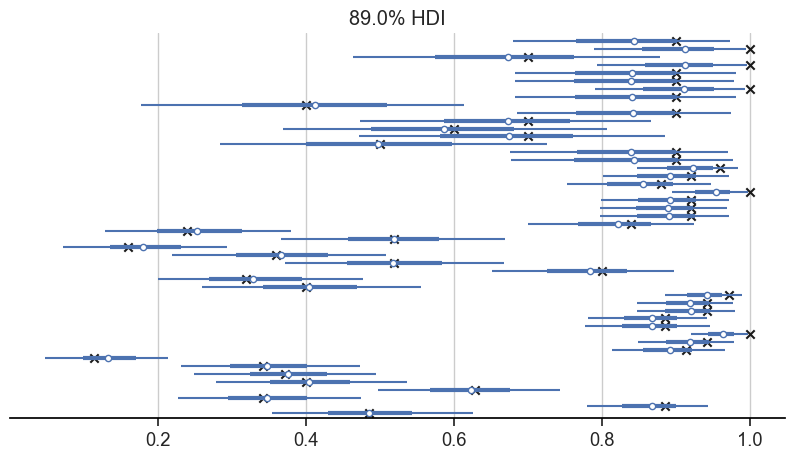

In [31]:
axs = az.plot_forest(
    trace_13_1,
    var_names="p",
    combined=True,
    hdi_prob=0.89,
    figsize=(10, 5),
)

ax = axs[0]
yticks = ax.get_yticks()
ax.scatter(frogs.propsurv, yticks[::-1], marker="x", color="k")

ax.get_yaxis().set_visible(False);

Note that there is shrinkage towards 0.5 coming from the priors on the alphas

Now let's try a multilevel model

In [32]:
coords = {
    "tank": frogs.index,
}
with pm.Model() as m13_2:
    # data
    tank_idx = pm.MutableData("tank_idx", frogs.index, dims="tank")
    density = pm.MutableData("density", frogs.density, dims="tank")

    # hyperpriors
    alpha_bar = pm.Normal("alpha_bar", mu=0, sigma=1.5)
    sigma = pm.Exponential("sigma", lam=1)

    # prior
    alpha = pm.Normal("alpha", mu=alpha_bar, sigma=sigma, dims="tank")

    # model
    p = pm.Deterministic("p", pm.math.invlogit(alpha[tank_idx]), dims="tank")
    p_bar = pm.Deterministic(
        "p_bar",
        pm.math.invlogit(alpha_bar),
    )

    # likelihood
    surv = pm.Binomial("surv", n=density, p=p, observed=frogs.surv, dims="tank")

    # inference button
    trace_13_2 = pm.sample(random_seed=RANDOM_SEED, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_bar, sigma, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


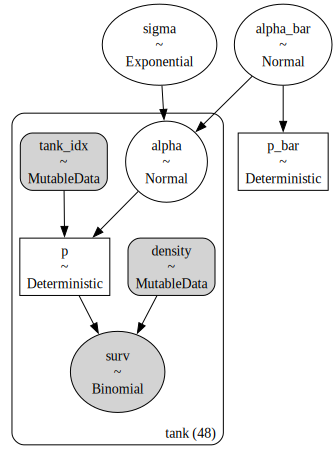

In [33]:
m13_2.to_graphviz()

In [34]:
az.summary(
    trace_13_2,
    var_names=["alpha_bar", "sigma"],
    round_to=2,
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_bar,1.34,0.25,0.89,1.81,0.0,0.0,4889.34,3550.01,1.0
sigma,1.61,0.21,1.23,2.01,0.0,0.0,2905.73,3306.22,1.0


We can plot the survival posteriors against those for the previous model and the observed values.
We also plot the posterior of `p_bar = invlogit(alpha_bar)`, the hyperparameter.

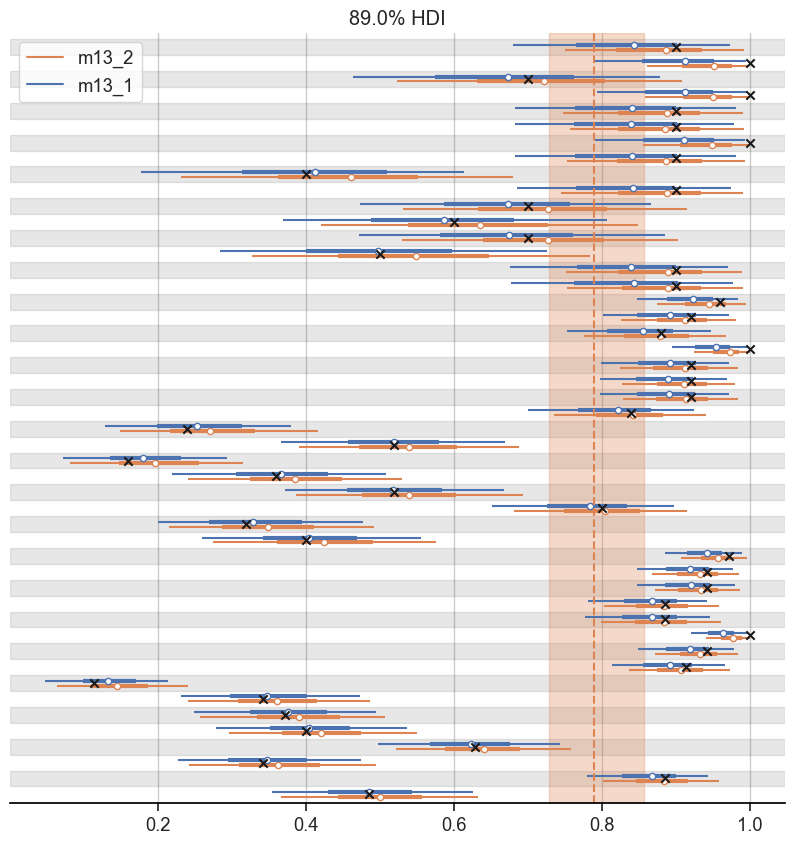

In [35]:
axs = az.plot_forest(
    [trace_13_1, trace_13_2],
    model_names=["m13_1", "m13_2"],
    var_names=["p"],
    combined=True,
    hdi_prob=0.89,
    figsize=(10, 10),
)

# plot observed values
ax = axs[0]
yticks = ax.get_yticks()
ax.scatter(
    frogs.propsurv, yticks[::-1], marker="x", color="k", zorder=2
)  # zorder brings it to the front

# plot posterior of p_bar
ax.axvline(trace_13_2.posterior.p_bar.mean(), color=colors[1], ls="--")
p_bar_hdi = az.hdi(trace_13_2.posterior.p_bar, hdi_prob=0.89)
ax.fill_betweenx(
    y=ax.get_ylim(),
    x1=p_bar_hdi.p_bar.sel(hdi="lower"),
    x2=p_bar_hdi.p_bar.sel(hdi="higher"),
    color=colors[1],
    alpha=0.3,
)

ax.get_yaxis().set_visible(False);

Note that the shrinkage is toward `p_bar` rather than towards 0.5.

Let's compare the WAIC of the different models:

In [36]:
models = {
    "m13.1": trace_13_1,
    "m13.2": trace_13_2,
}
az.compare(models, ic="waic", scale="deviance")

/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m13.2,0,199.762753,20.810154,0.000000,1.0,7.063485,0.000000,True,deviance
m13.1,1,214.918799,25.733306,15.156046,0.0,4.478671,3.693629,True,deviance


Recall that `p_waic` is the effective number of parameters - the penalty term for the complexity of the model.

## 13.2 Varying effects and the underfitting/overfitting trade-off

Let's simulate some pond data

In [37]:
alpha_bar_true = 1.5
sigma_true = 1.5
n_ponds = 60

# tadpoles in each pond
density = np.array([5, 10, 25, 35] * 15)
density.sort()

# true intercepts
alpha = rng.normal(loc=alpha_bar_true, scale=sigma_true, size=n_ponds)

# collect in a dataframe
ponds = pd.DataFrame(
    {
        "pond": np.arange(n_ponds),
        "density": density,
        "alpha_true": alpha,
    },
)
ponds["p_true"] = expit(ponds["alpha_true"])

# simulate survivors
ponds["surv"] = rng.binomial(n=ponds.density, p=ponds.p_true)

The non-pooled estimates are simply the empirical survival proportions:

In [38]:
ponds["p_nopool"] = ponds["surv"] / ponds["density"]

Now we build our hierarchical model

In [39]:
coords = {
    "pond": ponds.pond,
}
with pm.Model(coords=coords) as m13_3:
    # data
    pond_idx = pm.MutableData("pond_idx", ponds.pond, dims="pond")
    density = pm.MutableData("density", ponds.density, dims="pond")

    # hyperpriors
    alpha_bar = pm.Normal("alpha_bar", mu=0, sigma=1.5)
    sigma = pm.Exponential("sigma", lam=1)

    # priors
    alpha = pm.Normal("alpha", mu=alpha_bar, sigma=sigma, dims="pond")

    # model
    p = pm.Deterministic("p", pm.math.invlogit(alpha[pond_idx]), dims="pond")
    p_bar = pm.Deterministic("p_bar", pm.math.invlogit(alpha_bar))

    # likelihood
    surv = pm.Binomial("surv", n=density, p=p, observed=ponds.surv, dims="pond")

    trace_13_3 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_bar, sigma, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


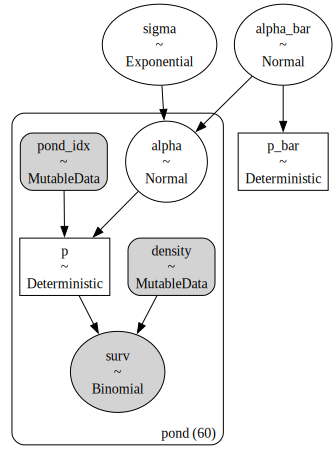

In [40]:
m13_3.to_graphviz()

In [41]:
# get pooled estimates
ponds["p_partpool"] = trace_13_3.posterior.p.mean(dim=["chain", "draw"])

# now get the errors
ponds["nopool_abs_err"] = (ponds["p_true"] - ponds["p_nopool"]).abs()
ponds["partpool_abs_err"] = (ponds["p_true"] - ponds["p_partpool"]).abs()

Let's compare the errors of the two models

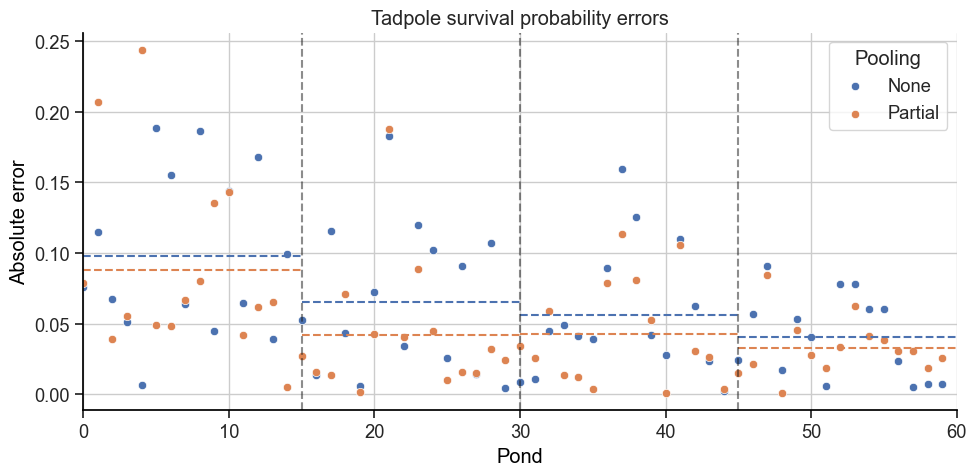

In [42]:
fig, ax = plt.subplots(figsize=(10, 5))

density_mean_errs = ponds.groupby("density")[
    ["nopool_abs_err", "partpool_abs_err"]
].mean()

thresholds = range(0, 61, 15)
for i, (density, mean_errs) in enumerate(density_mean_errs.iterrows()):
    ax.plot(
        thresholds[i : i + 2],
        [mean_errs["nopool_abs_err"], mean_errs["nopool_abs_err"]],
        color=colors[0],
        ls="--",
    )
    ax.plot(
        thresholds[i : i + 2],
        [mean_errs["partpool_abs_err"], mean_errs["partpool_abs_err"]],
        color=colors[1],
        ls="--",
    )


for threshold in thresholds[1:-1]:
    ax.axvline(threshold, ls="--", color="k", alpha=0.5)


sns.scatterplot(
    data=ponds, x="pond", y="nopool_abs_err", color=colors[0], label="None", ax=ax
)
sns.scatterplot(
    data=ponds, x="pond", y="partpool_abs_err", color=colors[1], label="Partial", ax=ax
)

ax.set(
    xlim=[0, 60],
    xlabel="Pond",
    ylabel="Absolute error",
    title="Tadpole survival probability errors",
)
ax.legend(title="Pooling")
plt.tight_layout();

The errors of the partially pooled model are reliably lower.

## 13.3 More than one type of cluster

Start by recreating the model from chapter 11

In [43]:
# load the data
chimps = load_data(CHIMPANZEES_FILE, delimiter=";")

# define id column
chimps["treatment_idx"] = chimps["prosoc_left"] + 2 * chimps["condition"]

treatment_mapper = {
    0: "R/N",
    1: "L/N",
    2: "R/P",
    3: "L/P",
}
chimps["treatment"] = chimps["treatment_idx"].replace(treatment_mapper)

# define id columns
chimps["actor_idx"] = chimps["actor"] - 1
chimps["block_idx"] = chimps["block"] - 1

Now the model

In [45]:
actors = chimps.sort_values("actor_idx").actor.unique()
treatments = chimps.sort_values("treatment_idx").treatment.unique()
coords = {
    "actor": actors,
    "treatment": treatments,
}
with pm.Model(coords=coords) as m11_4:
    # data
    actor_idx = pm.MutableData("actor", chimps.actor_idx, dims="obs")
    treatment_idx = pm.MutableData("treatment", chimps.treatment_idx, dims="obs")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1.5, dims="actor")
    beta = pm.Normal("beta", mu=0, sigma=0.5, dims="treatment")

    # linear model
    p = pm.Deterministic(
        "p", pm.math.invlogit(alpha[actor_idx] + beta[treatment_idx]), dims="obs"
    )

    # likelihood
    pulled_left = pm.Binomial(
        "pulled_left", n=1, p=p, observed=chimps.pulled_left, dims="obs"
    )

In [46]:
m11_4

      alpha ~ Normal(0, 1.5)
       beta ~ Normal(0, 0.5)
          p ~ Deterministic(f(beta, alpha))
pulled_left ~ Binomial(1, p)

Notice that this is learning a separate intercept for each chimp and each treatment.|

### 13.3.1 Multilevel chimpanzees

We improve the model above by adding partial pooling to the chimp intercepts and adding (partially pooled) coefficients for block.

In [60]:
actors = chimps.sort_values("actor_idx").actor.unique()
blocks = chimps.sort_values("block_idx").block.unique()
treatments = chimps.sort_values("treatment_idx").treatment.unique()
coords = {
    "actor": actors,
    "block": blocks,
    "treatment": treatments,
}
with pm.Model(coords=coords) as m13_4:
    # data
    actor_idx = pm.MutableData("actor", chimps.actor_idx, dims="obs")
    block_idx = pm.MutableData("block", chimps.block_idx, dims="obs")
    treatment_idx = pm.MutableData("treatment", chimps.treatment_idx, dims="obs")

    # hyperpriors
    alpha_bar = pm.Normal("alpha_bar", mu=0, sigma=1.5)
    sigma_alpha = pm.Exponential("sigma_alpha", lam=1)
    sigma_gamma = pm.Exponential("sigma_gamma", lam=1)

    # priors
    alpha = pm.Normal("alpha", mu=alpha_bar, sigma=sigma_alpha, dims="actor")
    beta = pm.Normal("beta", mu=0, sigma=0.5, dims="treatment")
    gamma = pm.Normal("gamma", mu=0, sigma=sigma_gamma, dims="block")

    # linear model
    p = pm.Deterministic(
        "p",
        pm.math.invlogit(alpha[actor_idx] + gamma[block_idx] + beta[treatment_idx]),
        dims="obs",
    )

    # likelihood
    pulled_left = pm.Binomial(
        "pulled_left", n=1, p=p, observed=chimps.pulled_left, dims="obs"
    )

    # sample the model
    trace_13_4 = pm.sample(random_seed=RANDOM_SEED, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_bar, sigma_alpha, sigma_gamma, alpha, beta, gamma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.


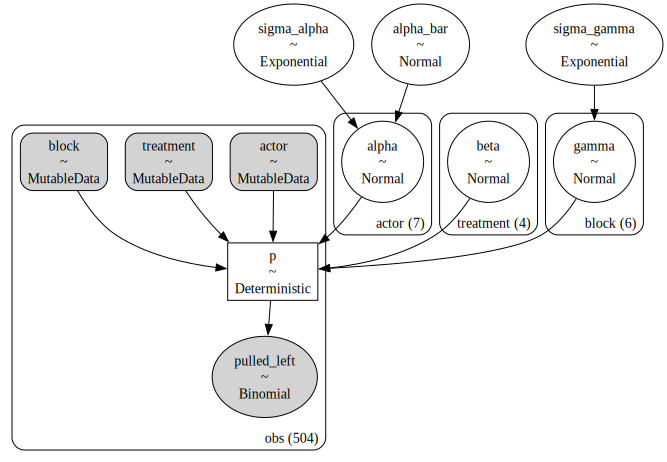

In [48]:
m13_4.to_graphviz()

Let's inspect the sampling

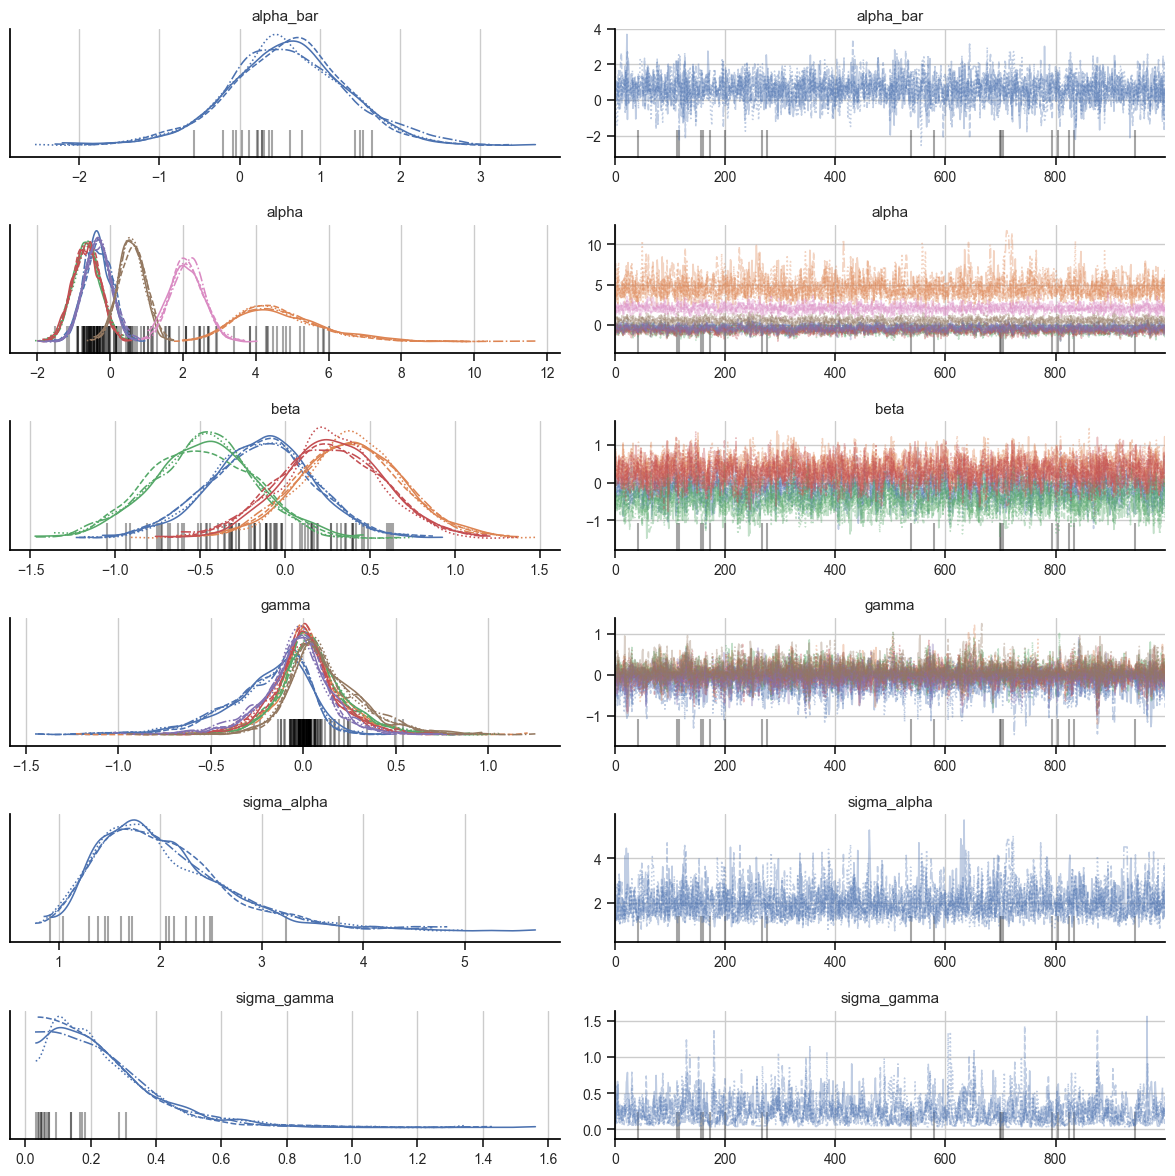

In [57]:
axs = az.plot_trace(
    trace_13_4,
    var_names=[
        "alpha",
        "beta",
        "gamma",
    ],
    filter_vars="like",
)
axs.ravel()[0].get_figure().tight_layout();

There have been some issues in sampling.
Let's look at a summary

In [52]:
az.summary(
    trace_13_4,
    var_names=[
        "alpha",
        "beta",
        "gamma",
    ],
    filter_vars="like",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_bar,0.59,0.75,-0.59,1.75,0.02,0.01,2124.96,2093.31,1.00
alpha[1],-0.34,0.36,-0.91,0.23,0.01,0.01,1218.73,1863.37,1.00
alpha[2],4.69,1.26,2.91,6.66,0.04,0.03,1515.21,1463.18,1.00
alpha[3],-0.64,0.37,-1.23,-0.04,0.01,0.01,1248.68,1960.22,1.00
alpha[4],-0.64,0.37,-1.25,-0.08,0.01,0.01,1237.68,2077.98,1.00
alpha[5],-0.34,0.36,-0.91,0.23,0.01,0.01,1229.94,1675.55,1.00
alpha[6],0.60,0.36,0.05,1.21,0.01,0.01,1096.92,1682.01,1.00
alpha[7],2.12,0.46,1.34,2.79,0.01,0.01,1651.59,2043.62,1.00
beta[R/N],-0.14,0.30,-0.64,0.33,0.01,0.01,1159.89,1783.74,1.00
beta[L/N],0.38,0.31,-0.10,0.87,0.01,0.01,1125.11,1951.96,1.00


Note that the number fof effective parameters is very low for $\sigma_{\gamma}$.

We can also plot the posteriors.

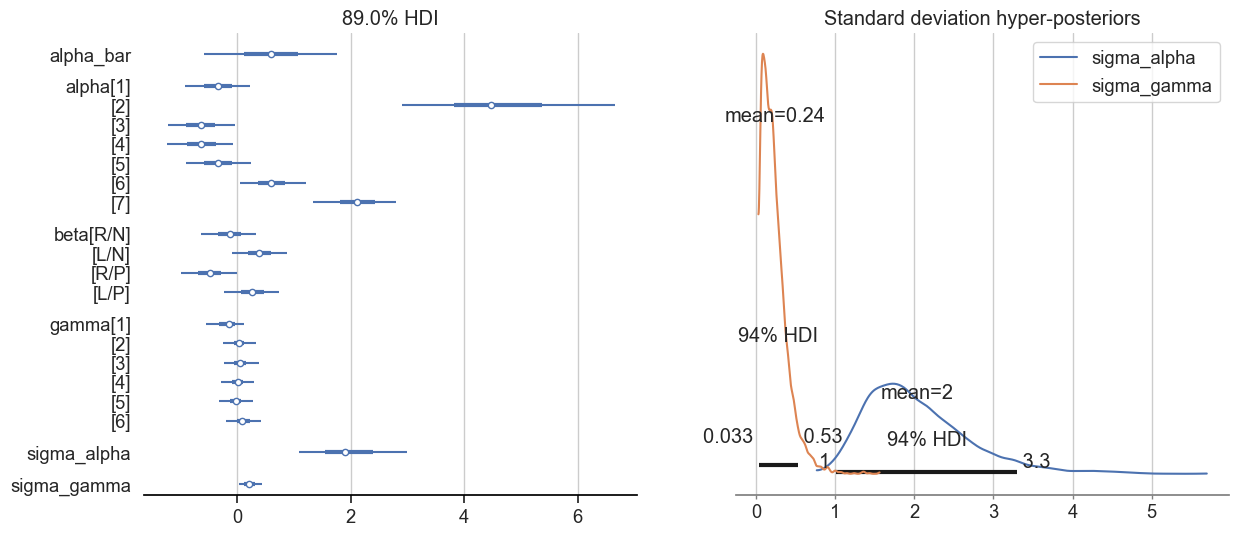

In [50]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 6))

az.plot_forest(
    trace_13_4,
    var_names=[
        "alpha",
        "beta",
        "gamma",
    ],
    filter_vars="like",
    combined=True,
    hdi_prob=0.89,
    ax=axs[0],
)

az.plot_posterior(
    trace_13_4,
    var_names=["sigma_alpha"],
    ax=axs[1],
    color=colors[0],
    label="sigma_alpha",
)
az.plot_posterior(
    trace_13_4,
    var_names=["sigma_gamma"],
    ax=axs[1],
    color=colors[1],
    label="sigma_gamma",
)
axs[1].set(title="Standard deviation hyper-posteriors");

There is very little variation between blocks.
For comparison, here's a model that ignores blocks.

In [62]:
actors = chimps.sort_values("actor_idx").actor.unique()
treatments = chimps.sort_values("treatment_idx").treatment.unique()
coords = {
    "actor": actors,
    "treatment": treatments,
}
with pm.Model(coords=coords) as m13_5:
    # data
    actor_idx = pm.MutableData("actor", chimps.actor_idx, dims="obs")
    treatment_idx = pm.MutableData("treatment", chimps.treatment_idx, dims="obs")

    # hyperpriors
    alpha_bar = pm.Normal("alpha_bar", mu=0, sigma=1.5)
    sigma_alpha = pm.Exponential("sigma_alpha", lam=1)

    # priors
    alpha = pm.Normal("alpha", mu=alpha_bar, sigma=sigma_alpha, dims="actor")
    beta = pm.Normal("beta", mu=0, sigma=0.5, dims="treatment")

    # linear model
    p = pm.Deterministic(
        "p",
        pm.math.invlogit(alpha[actor_idx] + beta[treatment_idx]),
        dims="obs",
    )

    # likelihood
    pulled_left = pm.Binomial(
        "pulled_left", n=1, p=p, observed=chimps.pulled_left, dims="obs"
    )

    # sample the model
    trace_13_5 = pm.sample(random_seed=RANDOM_SEED, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_bar, sigma_alpha, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


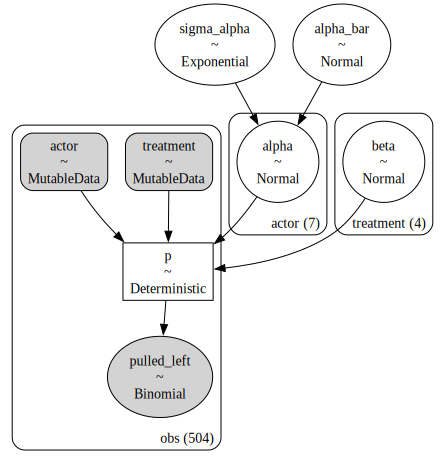

In [63]:
m13_5.to_graphviz()

Let's compare with WAIC values

In [66]:
az.compare(
    {
        "m13.4": trace_13_4,
        "m13.5": trace_13_5,
    },
    ic="waic",
    scale="deviance",
    seed=RANDOM_SEED,
)

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m13.5,0,531.356465,8.627486,0.000000,1.0,19.194710,0.000000,False,deviance
m13.4,1,532.310967,10.815134,0.954501,0.0,19.342832,1.872679,False,deviance


The simpler model excluding blocks has lower WAIC and fewer effective parameters, but the difference is easily within the standard error.

### 13.3.2 Even more clusters

We can also partial pool the treatments

In [67]:
actors = chimps.sort_values("actor_idx").actor.unique()
blocks = chimps.sort_values("block_idx").block.unique()
treatments = chimps.sort_values("treatment_idx").treatment.unique()
coords = {
    "actor": actors,
    "block": blocks,
    "treatment": treatments,
}
with pm.Model(coords=coords) as m13_6:
    # data
    actor_idx = pm.MutableData("actor", chimps.actor_idx, dims="obs")
    block_idx = pm.MutableData("block", chimps.block_idx, dims="obs")
    treatment_idx = pm.MutableData("treatment", chimps.treatment_idx, dims="obs")

    # hyperpriors
    alpha_bar = pm.Normal("alpha_bar", mu=0, sigma=1.5)
    sigma_alpha = pm.Exponential("sigma_alpha", lam=1)
    sigma_beta = pm.Exponential("sigma_beta", lam=1)
    sigma_gamma = pm.Exponential("sigma_gamma", lam=1)

    # priors
    alpha = pm.Normal("alpha", mu=alpha_bar, sigma=sigma_alpha, dims="actor")
    beta = pm.Normal("beta", mu=0, sigma=sigma_beta, dims="treatment")
    gamma = pm.Normal("gamma", mu=0, sigma=sigma_gamma, dims="block")

    # linear model
    p = pm.Deterministic(
        "p",
        pm.math.invlogit(alpha[actor_idx] + gamma[block_idx] + beta[treatment_idx]),
        dims="obs",
    )

    # likelihood
    pulled_left = pm.Binomial(
        "pulled_left", n=1, p=p, observed=chimps.pulled_left, dims="obs"
    )

    # sample the model
    trace_13_6 = pm.sample(random_seed=RANDOM_SEED, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_bar, sigma_alpha, sigma_beta, sigma_gamma, alpha, beta, gamma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.


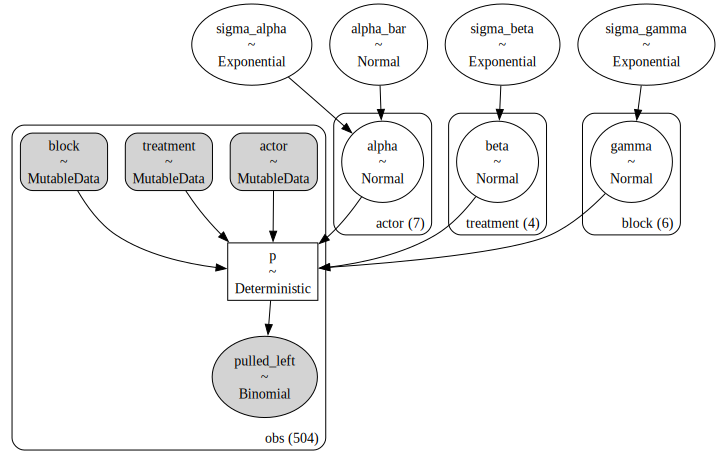

In [68]:
m13_6.to_graphviz()

Let's compare the $\beta$ parameters with the model that doesn't partially pool treatments.

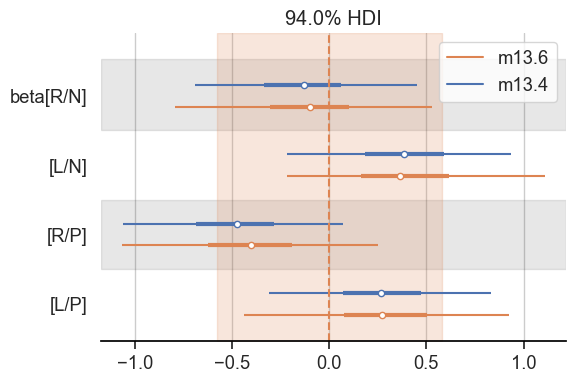

In [81]:
fig, ax = plt.subplots(figsize=(6, 4))

az.plot_forest(
    [trace_13_4, trace_13_6],
    model_names=["m13.4", "m13.6"],
    var_names=["beta"],
    combined=True,
    ax=ax,
)

# share +/- 1 grand stdev (based on the posterior mean)
ax.axvline(0, ls="--", color=colors[1])

sigma_beta_mean = trace_13_6.posterior.sigma_beta.mean().item()
ylim = ax.get_ylim()
ax.fill_betweenx(
    ylim,
    -sigma_beta_mean,
    sigma_beta_mean,
    color=colors[1],
    alpha=0.2,
);

I'm surprised by how large the grand standard deviation $\sigma_{\beta}$ is.
It doesn't lead to very much shrinkage.

## 13.4 Divergent transitions and non-centered priors

### 13.4.1 The Devil's Funnel

Let's define and try to sample a funky model.

In [84]:
with pm.Model() as m13_7:
    # priors
    nu = pm.Normal("nu", mu=0, sigma=3)
    x = pm.Normal("x", mu=0, sigma=pm.math.exp(nu))
    
    # sample
    trace_13_7 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1190 divergences after tuning. Increase `target_accept` or reparameterize.


In [85]:
az.summary(
    trace_13_7,
    round_to=2,
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
nu,3.64,1.75,0.51,6.64,0.53,0.38,10.77,14.10,1.29
x,30.17,476.61,-439.68,540.60,28.00,19.82,464.04,166.52,1.19


Let's have a look at the trace plot

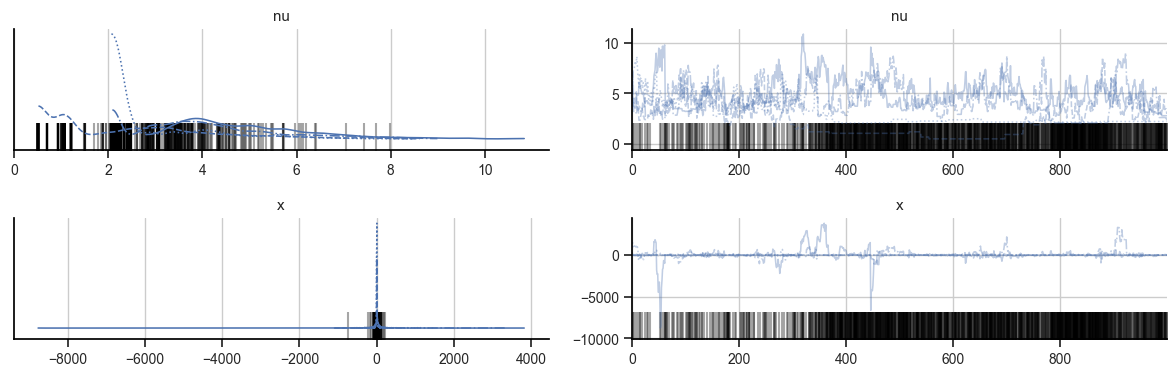

In [86]:
axs = az.plot_trace(
    trace_13_7,
)
axs.ravel()[0].get_figure().tight_layout();

It looks like $\nu$ isn't stationary and $x$ is spinning out to wild values.

Finally let's look at a pair plot

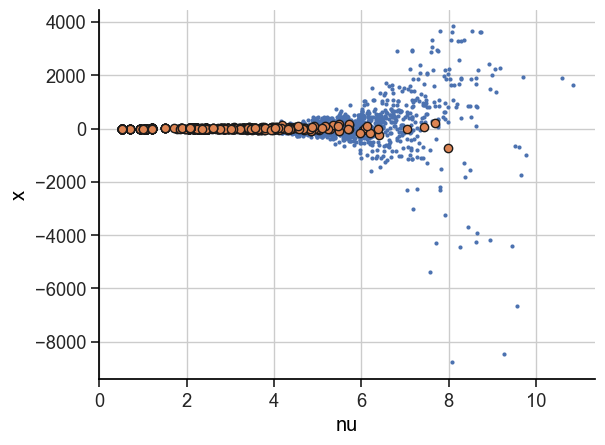

In [87]:
az.plot_pair(
    trace_13_7,
    divergences=True,
);

This shows the Devil's Funnel and the points at which divergences are appearing.

**Centred parameterisation:** The distribution of a variable is conditional on one or more other parameters.

Let's resample with a non-centred parameterisation:

In [88]:
with pm.Model() as m13_8:
    # priors
    nu = pm.Normal("nu", mu=0, sigma=3)
    z = pm.Normal("z", mu=0, sigma=1)
    x = pm.Deterministic("x", z * pm.math.exp(nu))
    
    # sample
    trace_13_8 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [89]:
az.summary(
    trace_13_8,
    round_to=2,
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
nu,0.03,3.03,-5.51,5.71,0.05,0.05,3851.54,2664.19,1.0
z,-0.03,0.98,-1.85,1.82,0.02,0.02,3640.14,2617.16,1.0
x,-21.92,1029.37,-53.26,79.78,18.32,12.96,3256.93,2899.19,1.0


The effective sample sizes look much healthier - even though $x$ has a huge standard deviation.

Let's have a look at the trace plot

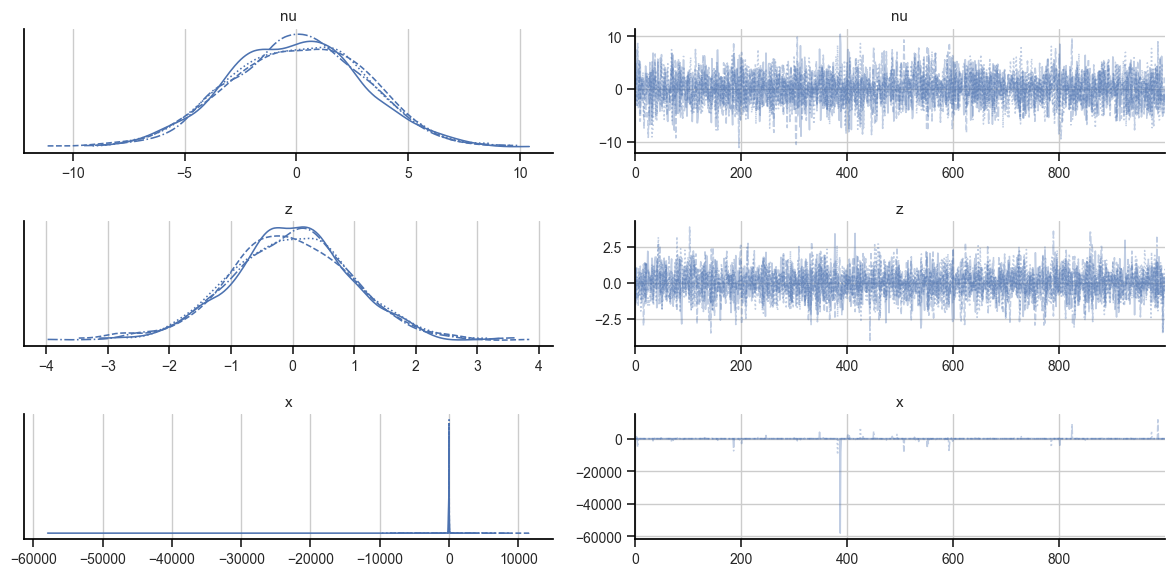

In [90]:
axs = az.plot_trace(
    trace_13_8,
)
axs.ravel()[0].get_figure().tight_layout();

Finally let's look at a pair plot

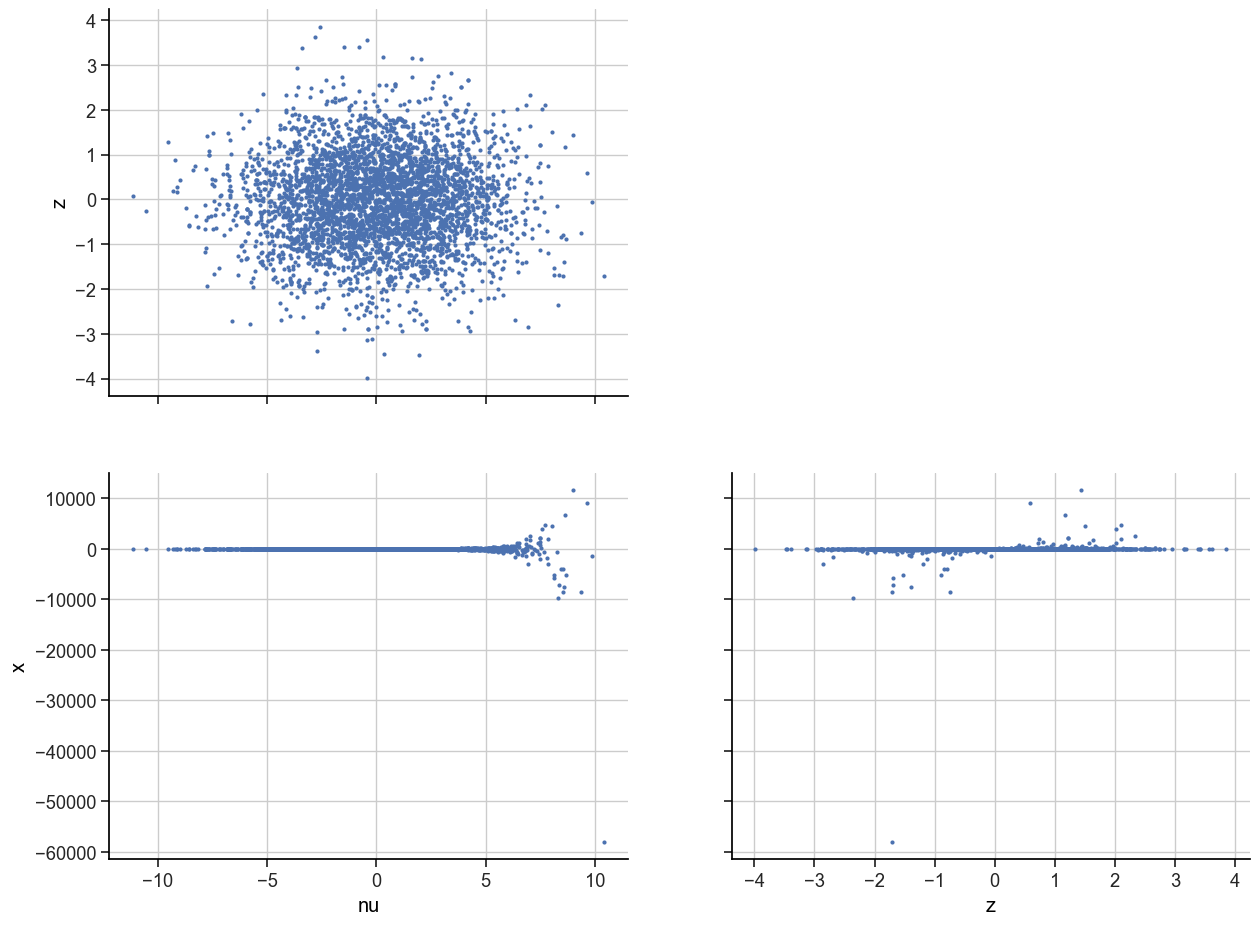

In [91]:
az.plot_pair(
    trace_13_8,
    divergences=True,
);

We still get wild outliers, but these don't lead to divergences because the sampling comes from $z$ and $\nu$ which play nicely together.

### 13.4.2 Non-centered chimpanzees

We can reduce the chance of divergences by increasing `target_accept` (the default is 0.8).
But, this will generally make sampling slower.

In [95]:
with m13_4:
    trace_13_4b = pm.sample(random_seed=RANDOM_SEED, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_bar, sigma_alpha, sigma_gamma, alpha, beta, gamma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [96]:
az.summary(
    trace_13_4b,
    var_names=[
        "alpha",
        "beta",
        "gamma",
    ],
    filter_vars="like",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_bar,0.56,0.71,-0.57,1.69,0.02,0.01,1919.08,1885.12,1.00
alpha[1],-0.38,0.37,-0.93,0.24,0.01,0.01,943.37,1800.49,1.01
alpha[2],4.64,1.31,2.66,6.29,0.04,0.03,1600.06,1421.72,1.00
alpha[3],-0.68,0.36,-1.27,-0.13,0.01,0.01,997.97,1642.63,1.01
alpha[4],-0.68,0.36,-1.28,-0.13,0.01,0.01,1009.13,1758.92,1.01
alpha[5],-0.37,0.36,-0.95,0.20,0.01,0.01,982.81,1815.34,1.01
alpha[6],0.56,0.37,-0.03,1.14,0.01,0.01,1022.23,1571.56,1.01
alpha[7],2.09,0.46,1.33,2.78,0.01,0.01,1457.82,2140.14,1.00
beta[R/N],-0.12,0.30,-0.60,0.33,0.01,0.01,974.12,1748.07,1.01
beta[L/N],0.41,0.30,-0.07,0.90,0.01,0.01,946.36,1534.02,1.01


This has more-or-less resolved the issue, but the effective sample sizes are still small.

Let's instead use a non-centred parameterisation.

In [98]:
actors = chimps.sort_values("actor_idx").actor.unique()
blocks = chimps.sort_values("block_idx").block.unique()
treatments = chimps.sort_values("treatment_idx").treatment.unique()
coords = {
    "actor": actors,
    "block": blocks,
    "treatment": treatments,
}
with pm.Model(coords=coords) as m13_4nc:
    # data
    actor_idx = pm.MutableData("actor", chimps.actor_idx, dims="obs")
    block_idx = pm.MutableData("block", chimps.block_idx, dims="obs")
    treatment_idx = pm.MutableData("treatment", chimps.treatment_idx, dims="obs")

    # hyperpriors
    alpha_bar = pm.Normal("alpha_bar", mu=0, sigma=1.5)
    sigma_alpha = pm.Exponential("sigma_alpha", lam=1)
    sigma_gamma = pm.Exponential("sigma_gamma", lam=1)
    
    # standardised intercepts
    z = pm.Normal("z", mu=0, sigma=1, dims="actor")
    x = pm.Normal("x", mu=0, sigma=1, dims="block")
    
    # define the previous variables as deterministic
    alpha = pm.Deterministic("alpha", alpha_bar + sigma_alpha * z, dims="actor")
    gamma = pm.Deterministic("gamma", sigma_gamma * x, dims="block")
    
    # treatment prior is unchanged
    beta = pm.Normal("beta", mu=0, sigma=0.5, dims="treatment")

    # linear model
    p = pm.Deterministic(
        "p",
        pm.math.invlogit(alpha[actor_idx] + gamma[block_idx] + beta[treatment_idx]),
        dims="obs",
    )

    # likelihood
    pulled_left = pm.Binomial(
        "pulled_left", n=1, p=p, observed=chimps.pulled_left, dims="obs"
    )

    # sample the model
    trace_13_4nc = pm.sample(random_seed=RANDOM_SEED, target_accept=0.9, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_bar, sigma_alpha, sigma_gamma, z, x, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Converged quickly without divergences

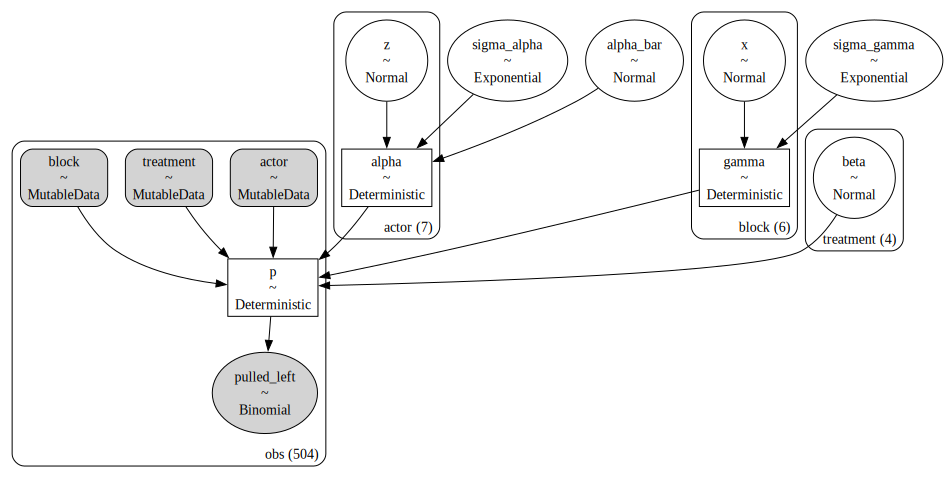

In [99]:
m13_4nc.to_graphviz()

Let's look at the convergence characteristics

In [100]:
az.summary(
    trace_13_4nc,
    var_names=[
        "alpha",
        "beta",
        "gamma",
    ],
    filter_vars="like",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_bar,0.62,0.70,-0.58,1.67,0.02,0.02,966.78,1557.78,1.0
beta[R/N],-0.12,0.30,-0.61,0.34,0.01,0.00,2298.10,2558.79,1.0
beta[L/N],0.41,0.29,-0.05,0.89,0.01,0.00,2036.28,2399.99,1.0
beta[R/P],-0.47,0.30,-0.95,0.01,0.01,0.00,2307.45,2777.41,1.0
beta[L/P],0.29,0.30,-0.16,0.79,0.01,0.00,2169.49,2556.87,1.0
sigma_alpha,2.00,0.63,1.06,2.88,0.02,0.01,1408.92,1773.66,1.0
sigma_gamma,0.20,0.17,0.00,0.41,0.00,0.00,1705.43,1955.35,1.0
alpha[1],-0.37,0.36,-0.93,0.20,0.01,0.01,2369.21,2672.67,1.0
alpha[2],4.68,1.35,2.82,6.59,0.03,0.02,3434.08,2511.84,1.0
alpha[3],-0.67,0.37,-1.27,-0.11,0.01,0.01,2565.53,2437.86,1.0


The number of effective samples are much more healthy. We can plot these against each other.

In [214]:
var_names = [
    "alpha",
    "beta",
    "gamma",
    "alpha_bar",
    "sigma_alpha",
    "sigma_gamma",
]

centred_ess = az.ess(
    trace_13_4,
    var_names=var_names,
)
non_centred_ess = az.ess(
    trace_13_4nc,
    var_names=var_names,
)

ess_df = pd.concat([
        pd.DataFrame(
            data={
                "variable": var,
                "centred_ess": np.r_[centred_ess[var].to_numpy()], # np.r_ transforms 0d-array -> 1d-array
                "non_centred_ess": np.r_[non_centred_ess[var].to_numpy()],
            },
        ) for var in centred_ess.data_vars
    ],
    axis=0,
)

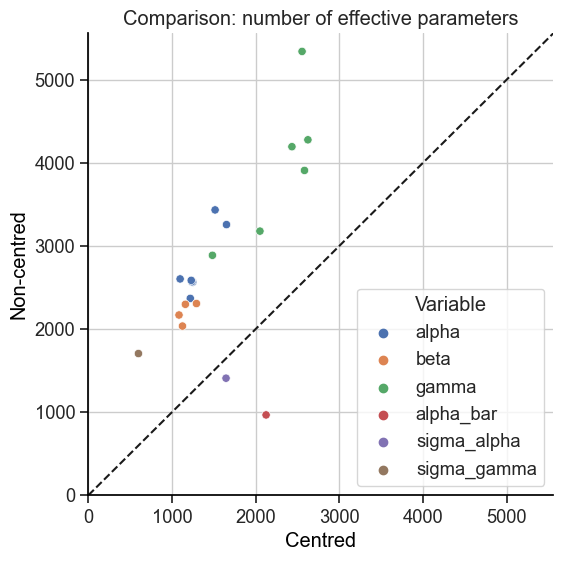

In [218]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.scatterplot(
    ess_df,
    x="centred_ess",
    y="non_centred_ess",
    hue="variable",
)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
lim = [0, max(xlim[1], ylim[1])]

ax.plot([0, lim[1]], [0, lim[1]], color="k", ls="--")

ax.set(
    xlim=lim,
    ylim=lim,
    xlabel="Centred",
    ylabel="Non-centred",
    title="Comparison: number of effective parameters",
)
ax.legend(title="Variable", loc="lower right");